In [2]:
from keras.preprocessing.image import ImageDataGenerator
train_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/train"
val_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/val"
test_dir = "../데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/test"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 67471 images belonging to 7 classes.
Found 14458 images belonging to 7 classes.
Found 14459 images belonging to 7 classes.


In [3]:
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import EfficientNetB2 

base_model = EfficientNetB2(include_top=False,
                            weights= None,
                            input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

In [4]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_name = "efficientnetb1"
checkpoint_path = f"saved_models/{model_name}.hdf5"
checkpoint_cb = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True,monitor='val_loss')
early_stop_cb = EarlyStopping(patience=15,restore_best_weights=True)

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=300,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint_cb,early_stop_cb])

Epoch 1/300
2108/2108 [==============================] - ETA: 0s - loss: 1.4990 - accuracy: 0.4184
Epoch 1: val_loss improved from inf to 1.16027, saving model to saved_models\efficientnetb1.hdf5
2108/2108 [==============================] - 943s 441ms/step - loss: 1.4990 - accuracy: 0.4184 - val_loss: 1.1603 - val_accuracy: 0.6010
Epoch 2/300
2108/2108 [==============================] - ETA: 0s - loss: 0.8540 - accuracy: 0.7109
Epoch 2: val_loss improved from 1.16027 to 0.77292, saving model to saved_models\efficientnetb1.hdf5
2108/2108 [==============================] - 742s 352ms/step - loss: 0.8540 - accuracy: 0.7109 - val_loss: 0.7729 - val_accuracy: 0.7395
Epoch 3/300
2108/2108 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.7668
Epoch 3: val_loss improved from 0.77292 to 0.67535, saving model to saved_models\efficientnetb1.hdf5
2108/2108 [==============================] - 562s 267ms/step - loss: 0.6904 - accuracy: 0.7668 - val_loss: 0.6754 - val_accuracy: 

In [7]:
model.evaluate(test_generator)


452/452 [==============================] - 32s 70ms/step - loss: 0.5127 - accuracy: 0.8318


[0.5127319097518921, 0.8318002820014954]

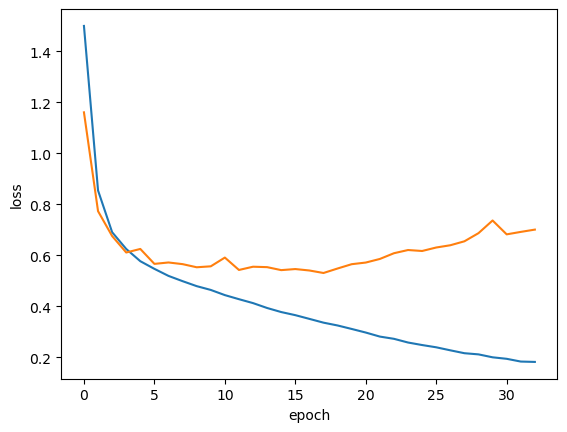

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

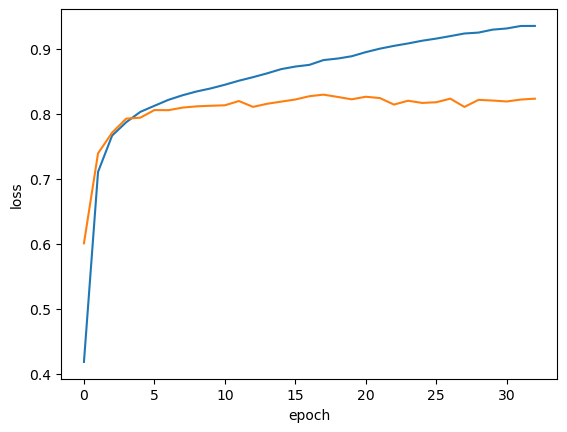

In [9]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()